In [1]:
import pandas as pd
import pytz
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("combined_spotify_history.csv")

# print(df.columns)
# Index(['ts', 'platform', 'ms_played', 'conn_country', 'ip_addr',
#        'master_metadata_track_name', 'master_metadata_album_artist_name',
#        'master_metadata_album_album_name', 'spotify_track_uri', 'episode_name',
#        'episode_show_name', 'spotify_episode_uri', 'audiobook_title',
#        'audiobook_uri', 'audiobook_chapter_uri', 'audiobook_chapter_title',
#        'reason_start', 'reason_end', 'shuffle', 'skipped', 'offline',
#        'offline_timestamp', 'incognito_mode'],
#       dtype='object')



/tmp/ipykernel_6534/3182799635.py:6: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("combined_spotify_history.csv")


In [2]:
df['play_datetime'] = df.apply(
    lambda row: pd.to_datetime(row['offline_timestamp'], unit='ms') if row['offline'] else pd.to_datetime(row['ts']),
    axis=1
)

df['play_datetime'] = pd.to_datetime(df['play_datetime'], utc=True)

ist = pytz.timezone('Asia/Kolkata')
df['play_datetime'] = df['play_datetime'].dt.tz_convert(ist)

In [3]:
columns_to_keep = [
    "play_datetime",
    "ms_played",
    "master_metadata_track_name",
    "master_metadata_album_artist_name",
    "master_metadata_album_album_name",
]
df = df[columns_to_keep]
df.head()

,play_datetime,ms_played,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name
0,2021-05-10 12:01:02+05:30,124778,Moving On,Marshmello,Moving On
1,2021-05-10 12:03:37+05:30,156346,Here With Me,Marshmello,Here With Me
2,2021-05-10 12:07:17+05:30,186024,Tongue Tied (with YUNGBLUD & blackbear),Marshmello,Tongue Tied (with YUNGBLUD & blackbear)
3,2021-05-10 12:10:28+05:30,191000,Proud,Marshmello,Joytime III
4,2021-05-10 12:13:54+05:30,205119,Silence - Illenium Remix,Marshmello,Silence - Illenium Remix


In [4]:
len(df)

145841

In [5]:
df['date'] = df['play_datetime'].dt.date

In [6]:
from datetime import date

rows_before_2021 = df[df['date'] < date(2021, 1, 1)]
print(f"Number of rows before 2021: {len(rows_before_2021)}")

df = df[df['date'] >= date(2021, 1, 1)]


Number of rows before 2021: 1075


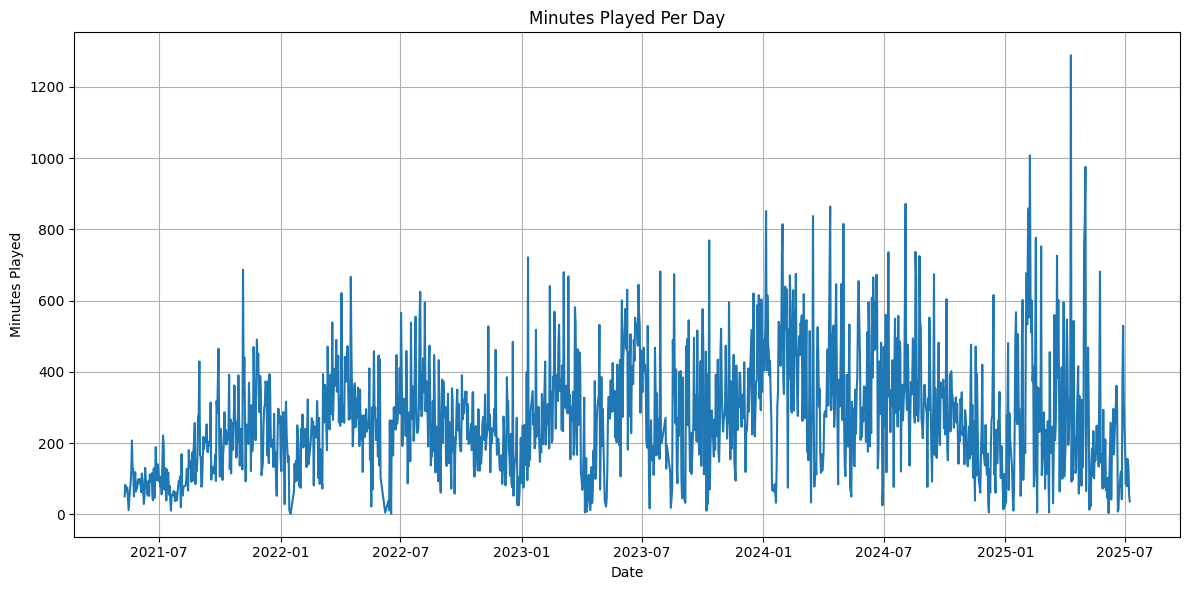

In [7]:
df['minutes_played'] = df['ms_played'] / 60000

daily_play = df.groupby('date')['minutes_played'].sum()

plt.figure(figsize=(12, 6))
daily_play.plot()
plt.title("Minutes Played Per Day")
plt.xlabel("Date")
plt.ylabel("Minutes Played")
plt.grid(True)
plt.tight_layout()
plt.show()

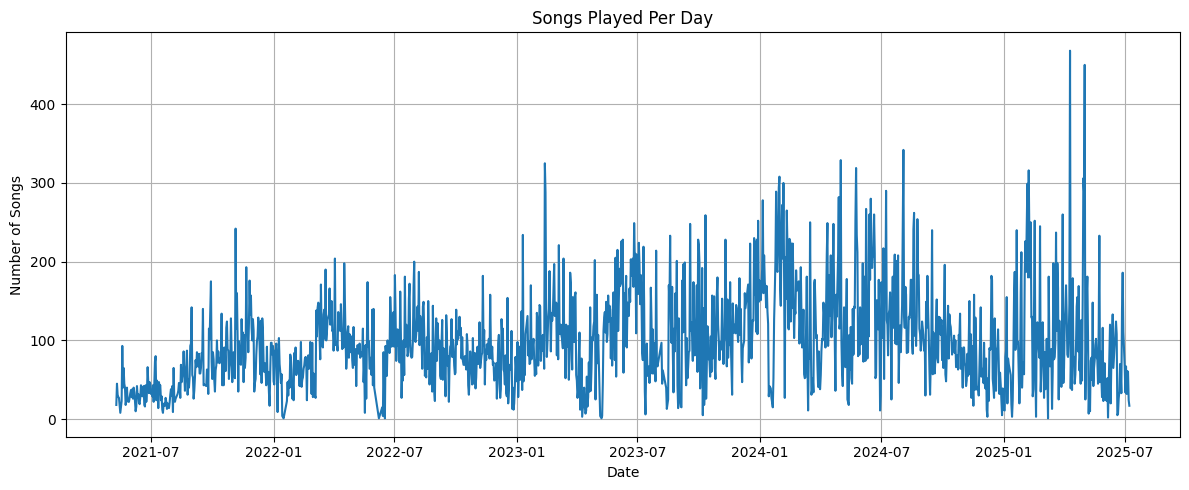

In [8]:
df['count'] = 1
songs_over_time = df.groupby('date')['count'].sum()

plt.figure(figsize=(12, 5))
songs_over_time.plot()
plt.title("Songs Played Per Day")
plt.xlabel("Date")
plt.ylabel("Number of Songs")
plt.grid(True)
plt.tight_layout()
plt.show()


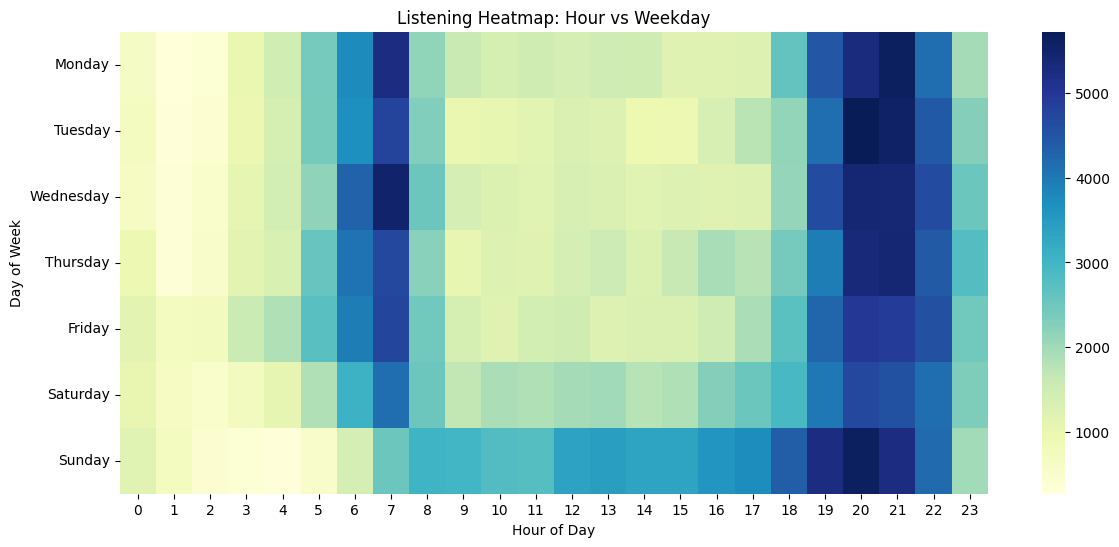

In [9]:
df['hour'] = df['play_datetime'].dt.hour
df['weekday'] = df['play_datetime'].dt.day_name()

pivot = df.pivot_table(values='minutes_played', index='weekday', columns='hour', aggfunc='sum').fillna(0)

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot = pivot.reindex(weekday_order)

plt.figure(figsize=(14, 6))
sns.heatmap(pivot, cmap="YlGnBu")
plt.title("Listening Heatmap: Hour vs Weekday")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()


In [48]:
artist_song_stats = df.groupby(['master_metadata_album_artist_name', 'master_metadata_track_name']).agg({
    'ms_played': 'sum'
}).reset_index()

artist_total_play = artist_song_stats.groupby('master_metadata_album_artist_name')['ms_played'].sum().reset_index()

artist_song_count = artist_song_stats.groupby('master_metadata_album_artist_name')['master_metadata_track_name'].nunique().reset_index()

artist_summary = artist_total_play.merge(artist_song_count, on='master_metadata_album_artist_name')
artist_summary.columns = ['artist', 'total_play_time_ms', 'unique_songs']

artist_summary['total_play_time_hours'] = artist_summary['total_play_time_ms'] / (1000 * 60 * 60)

artist_summary = artist_summary.sort_values(by='total_play_time_ms', ascending=False).head(10)
print(artist_summary)



                 artist  total_play_time_ms  unique_songs  \
2131             NEFFEX           896759139           160   
2138                 NF           735381425            64   
944              Eminem           361214272            22   
153       Alec Benjamin           357929273            28   
3336       XXXTENTACION           338601817            36   
2808       Shawn Mendes           214890470            19   
1496      Justin Bieber           211070438            34   
1290    Imagine Dragons           197336931            22   
397       Billie Eilish           194967427            27   
1742  League of Legends           193223798            40   

      total_play_time_hours  
2131             249.099761  
2138             204.272618  
944              100.337298  
153               99.424798  
3336              94.056060  
2808              59.691797  
1496              58.630677  
1290              54.815814  
397               54.157619  
1742              53.673277 

In [49]:
song_stats = df.groupby('master_metadata_track_name').agg({
    'ms_played': 'sum',
    'play_datetime': 'count' 
}).reset_index()

song_stats.columns = ['track_name', 'total_play_time_ms', 'play_count']

song_stats['total_play_time_hours'] = song_stats['total_play_time_ms'] / (1000 * 60 * 60)

song_stats_playtime = song_stats.sort_values(by='total_play_time_ms', ascending=False).head(10)
print(song_stats_playtime)

song_stats_playcount = song_stats.sort_values(by='play_count', ascending=False).head(10)
print(song_stats_playcount)


              track_name  total_play_time_ms  play_count  \
932      Beautiful Scars           104431020         588   
8908                idfc            88286670         395   
3743            It's You            87053112         461   
1843             Destiny            86606877         448   
5461               Older            81094284         461   
2908            Grateful            77545111         470   
1482                Cold            74223295         422   
9372  you broke me first            73129364         480   
8093      Water Fountain            72221417         359   
2434             Falling            71567546         472   

      total_play_time_hours  
932               29.008617  
8908              24.524075  
3743              24.181420  
1843              24.057466  
5461              22.526190  
2908              21.540309  
1482              20.617582  
9372              20.313712  
8093              20.061505  
2434              19.879874  
         

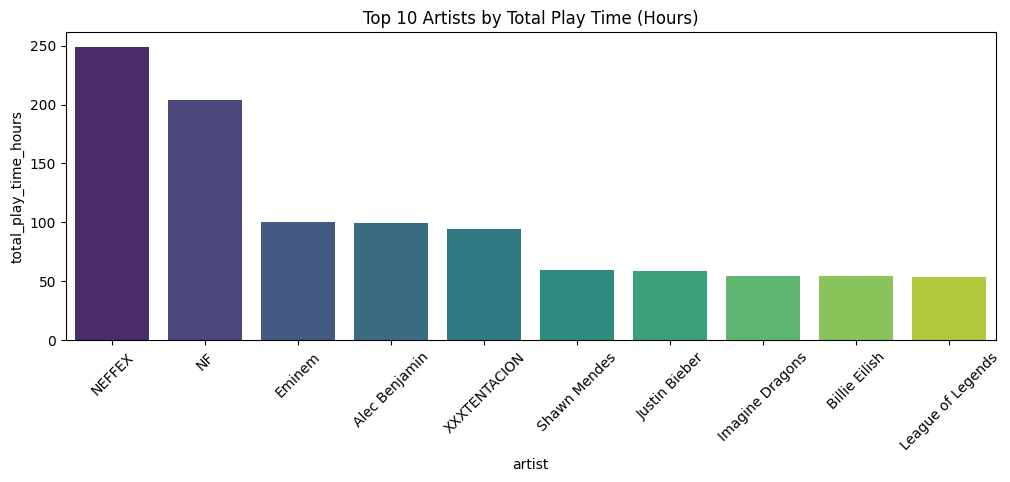

In [58]:
plt.figure(figsize=(12, 4))
sns.barplot(data=artist_summary, x='artist', y='total_play_time_hours',hue='artist', palette='viridis')
plt.xticks(rotation=45)
plt.title('Top 10 Artists by Total Play Time (Hours)')
plt.show()


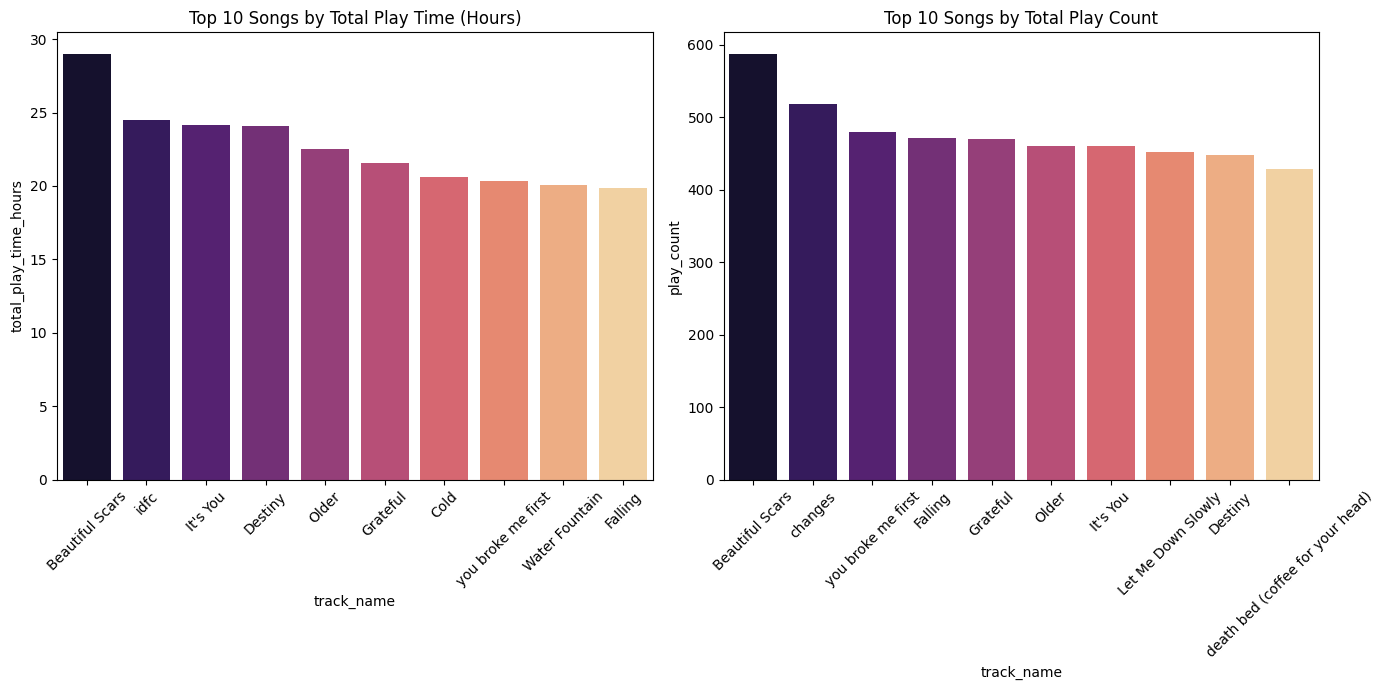

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

sns.barplot(data=song_stats_playtime, x='track_name', y='total_play_time_hours', hue='track_name', palette='magma', ax=axes[0])
axes[0].set_title('Top 10 Songs by Total Play Time (Hours)')

sns.barplot(data=song_stats_playcount, x='track_name', y='play_count', hue='track_name', palette='magma', ax=axes[1])
axes[1].set_title('Top 10 Songs by Total Play Count')

for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


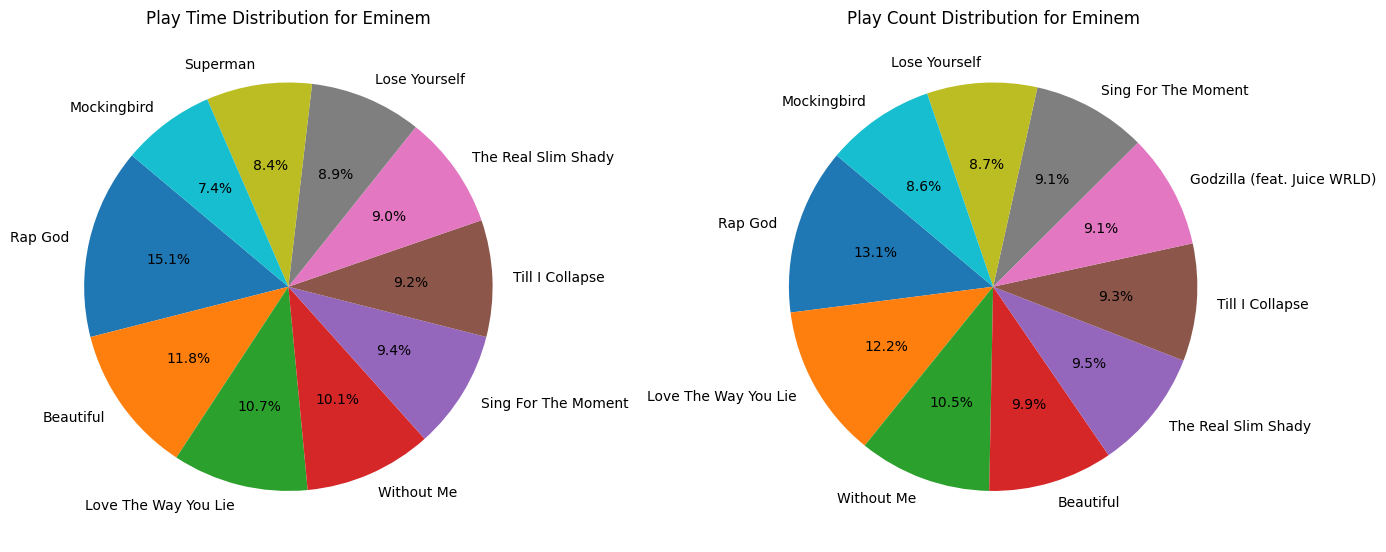

In [43]:
artist_name = "Eminem"

artist_df = df[df['master_metadata_album_artist_name'] == artist_name]
song_stats = artist_df.groupby('master_metadata_track_name').agg({
    'ms_played': 'sum',
    'play_datetime': 'count'
}).reset_index()

count = 10
song_stats['play_time_hours'] = song_stats['ms_played'] / (1000 * 60 * 60)

song_stats_time = song_stats.sort_values(by='ms_played', ascending=False).head(count)
song_stats_count = song_stats.sort_values(by='play_datetime', ascending=False).head(count)

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].pie(song_stats_time['play_time_hours'], labels=song_stats_time['master_metadata_track_name'], autopct='%1.1f%%', startangle=140)
axes[0].set_title(f"Play Time Distribution for {artist_name}")

axes[1].pie(song_stats_count['play_datetime'], labels=song_stats_count['master_metadata_track_name'], autopct='%1.1f%%', startangle=140)
axes[1].set_title(f"Play Count Distribution for {artist_name}")

plt.tight_layout()
plt.show()
